<a href="https://colab.research.google.com/github/cineguerrilha/Python_Miniscope/blob/main/PIMPIN_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PIMPN (Python Integrated Miniscope Pipeline Notebook)**

**Version: 0.8.1**

**Modified By George Nascimento to use GoogleDrive**

This Colab Notebook has been designed to analyze calcium imaging and behavior videos directly on the cloud. It relies on a Dropbox API, CaImAn, which itself uses NormCorre for motion correction as well as Constrained Non-Negative Matrix Factorization (CNMF/CNMFE) for source extraction. Behavior video can be analyzed automatically using DeepLabCut and your own DeepPose model (currently working on making pre-trained models available).



This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 3 of the License, or any later version.

Contact: etterguillaume@gmail.com

# Access to GoogleDrive

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path_to_analyze = '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/'
!ls $path_to_analyze


Mounted at /content/gdrive/
Analysis     msCam19.avi  msCam28.avi  msCam37.avi  msCam4.avi
msCam10.avi  msCam1.avi   msCam29.avi  msCam38.avi  msCam5.avi
msCam11.avi  msCam20.avi  msCam2.avi   msCam39.avi  msCam6.avi
msCam12.avi  msCam21.avi  msCam30.avi  msCam3.avi   msCam7.avi
msCam13.avi  msCam22.avi  msCam31.avi  msCam40.avi  msCam8.avi
msCam14.avi  msCam23.avi  msCam32.avi  msCam41.avi  msCam9.avi
msCam15.avi  msCam24.avi  msCam33.avi  msCam42.avi  settings_and_notes.dat
msCam16.avi  msCam25.avi  msCam34.avi  msCam43.avi  timestamp.dat
msCam17.avi  msCam26.avi  msCam35.avi  msCam44.avi
msCam18.avi  msCam27.avi  msCam36.avi  msCam45.avi


# Get informations about the virtual machine being used

In [4]:
# Disk information
!df -h
# CPU information
!lscpu | grep "MHz"
# If using a GPU
!nvidia-smi -L
!nvcc --version
# Memory information
!cat /proc/meminfo | grep 'MemAvailable'

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   37G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G   28K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            69G   35G   35G  50% /content/gdrive
CPU MHz:             2199.998
GPU 0: Tesla T4 (UUID: GPU-cfa5d69c-1313-73a8-64ac-77bd433a80e0)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
MemAvailable:   12475440 kB


# Parameters

In [5]:
access_token = '' # Get your access token from https://www.dropbox.com/developers/apps
experimentName='Analysis'
#path_to_analyze = '/content/gdrive/MyDrive/PostTrauma/H14_M40_S47/'
analyze_behavior = False
path_to_DLC_model = '' # Change yours here. Should be a zip file containing your full, trained model
spatial_downsampling = 3 # Drastically speeds up processing. 2-3 recommended
isnonrigid = False
path_to_results = '' # Where to save the data
alert_gmail = '_' # You can leave your Gmail adress to be notified when your analysis is done
alert_gmail_password = '_' # Password to your Gmail account
 
save_hdf5=False
 
print('Parameters saved. Ready to start analyzing')

Parameters saved. Ready to start analyzing


# Install and import dependencies

In [6]:
from datetime import datetime
import scipy.io as sio
import re
import os
import h5py
import csv
import tensorflow as tf
import time
import logging
import zipfile
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import numpy as np
from moviepy.editor import *
import smtplib



Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3612672/45929032 bytes (7.9%)7733248/45929032 bytes (16.8%)11780096/45929032 bytes (25.6%)15777792/45929032 bytes (34.4%)19906560/45929032 bytes (43.3%)23986176/45929032 bytes (52.2%)28049408/45929032 bytes (61.1%)32251904/45929032 bytes (70.2%)36388864/45929032 bytes (79.2%)40665088/45929032 bytes (88.5%)44933120/45929032 bytes (97.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [7]:
# Install CaImAn

#! pip install -U pynwb
!git clone https://github.com/etterguillaume/CaImAn.git
#!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install -e .

!pip install tifffile
!pip install ipyparallel
!pip install peakutils

%cd '/content/CaImAn/'
!python caimanmanager.py install --inplace

!export MKL_NUM_THREADS=1
!export OPENBLAS_NUM_THREADS=1

# This is for GPU accelaration
!pip install pycuda
!pip install scikit-cuda

import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
import peakutils

Cloning into 'CaImAn'...
remote: Enumerating objects: 18836, done.
remote: Total 18836 (delta 0), reused 0 (delta 0), pack-reused 18836
Receiving objects: 100% (18836/18836), 459.74 MiB | 35.13 MiB/s, done.
Resolving deltas: 100% (12556/12556), done.
Checking out files: 100% (276/276), done.
/content/CaImAn
Obtaining file:///content/CaImAn
  Running setup.py develop for caiman
     |████████████████████████████████| 204kB 7.7MB/s 
/content/CaImAn
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
Installed /root/caiman_data
     |████████████████████████████████| 1.6MB 7.5MB/s 
     |██████████████████████████████

# Get information from the experiment
This is particularily important to register the date/time and name of the experiment, which are also use to create specific analysis folders containing all the analyzed data (calcium imaging and behavior). Additionnaly, timestamps are retrieved and allow to realign calcium imaging with behavior videos

In [8]:
now = datetime.now()
analysis_time = now.strftime("%Y-%m-%d %H:%M") # This is to register when the analysis was performed
print('Analysis started on ' + analysis_time)

analysis_start = time.time() # This is to register the time spent analyzing


print('Name of the experiment to analyze: ' + experimentName)

dirExperimentName = path_to_analyze + experimentName
 
try:
    # Create target Directory
    os.mkdir(dirExperimentName)
    print("Directory " , dirExperimentName ,  " Created") 
except FileExistsError:
    print("Directory " , dirExperimentName ,  " already exists")
    
print(path_to_analyze)



Analysis started on 2021-01-31 17:56
Name of the experiment to analyze: Analysis
Directory  /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis  already exists
/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/


# Extract the date/time of the experiment and save as a timestamp variable
The date/time values are extracted from the automatic DAQ folder organization (might not work if you renamed your folders)

In [9]:
try:
  from datetime import datetime
  splitname = str.split(path_to_analyze, '/')

  dateStrPart = splitname[-3]
  timeStrPart = splitname[-2]

  date_result = str.split(dateStrPart, '_')
  month = int(date_result[0])
  day = int(date_result[1])
  year = int(date_result[2])

  timeStrPart = re.sub('[HSM]','', timeStrPart)
  time_result = str.split(timeStrPart,'_')
  
  hour = int(time_result[0])
  minute = int(time_result[1])
  seconds = int(time_result[2])
  
  experiment_timestamp = datetime.timestamp(datetime(year,month,day,hour,minute,seconds))
  #dateNum = date.toordinal(date(year,month,day,hour,minute,seconds))

except:
  print('Could not retrieve date information')

# Access GoogleDrive and download miniscope video files


In [10]:
sessionFilesResponse = os.listdir(path_to_analyze)
filesList = []
msFileList = []
datFileList = []
 
for file in sessionFilesResponse:
  filesList.append(file)
 
for i in filesList[:]:
  if i.startswith('ms') and i.endswith('.avi'):
    msFileList.append(i)
  if i.endswith('.dat'):
    datFileList.append(i)
    
msFileList = sorted(msFileList, key=lambda x: int(re.sub('[msCam.avi]','', x)))
 
# FOR Quick BETA TESTING
msFileList = msFileList[0:40]
 
print('Miniscope files in folder:')
print(msFileList)
 
if len(msFileList) == 0:
  print("No miniscope avi files found")

Miniscope files in folder:
['msCam1.avi', 'msCam2.avi', 'msCam3.avi', 'msCam4.avi', 'msCam5.avi', 'msCam6.avi', 'msCam7.avi', 'msCam8.avi', 'msCam9.avi', 'msCam10.avi', 'msCam11.avi', 'msCam12.avi', 'msCam13.avi', 'msCam14.avi', 'msCam15.avi', 'msCam16.avi', 'msCam17.avi', 'msCam18.avi', 'msCam19.avi', 'msCam20.avi', 'msCam21.avi', 'msCam22.avi', 'msCam23.avi', 'msCam24.avi', 'msCam25.avi', 'msCam26.avi', 'msCam27.avi', 'msCam28.avi', 'msCam29.avi', 'msCam30.avi', 'msCam31.avi', 'msCam32.avi', 'msCam33.avi', 'msCam34.avi', 'msCam35.avi', 'msCam36.avi', 'msCam37.avi', 'msCam38.avi', 'msCam39.avi', 'msCam40.avi']


In [11]:
import shutil
for fname in msFileList:
    src = os.path.join(path_to_analyze, fname)
    dst = os.path.join(dirExperimentName, fname)
    shutil.copyfile(src, dst)
for fname in datFileList:
    src = os.path.join(path_to_analyze, fname)
    dst = os.path.join(dirExperimentName, fname)
    shutil.copyfile(src, dst)
 
print('Files copyed for analysis:')
print(msFileList)
print(datFileList)

Files copyed for analysis:
['msCam1.avi', 'msCam2.avi', 'msCam3.avi', 'msCam4.avi', 'msCam5.avi', 'msCam6.avi', 'msCam7.avi', 'msCam8.avi', 'msCam9.avi', 'msCam10.avi', 'msCam11.avi', 'msCam12.avi', 'msCam13.avi', 'msCam14.avi', 'msCam15.avi', 'msCam16.avi', 'msCam17.avi', 'msCam18.avi', 'msCam19.avi', 'msCam20.avi', 'msCam21.avi', 'msCam22.avi', 'msCam23.avi', 'msCam24.avi', 'msCam25.avi', 'msCam26.avi', 'msCam27.avi', 'msCam28.avi', 'msCam29.avi', 'msCam30.avi', 'msCam31.avi', 'msCam32.avi', 'msCam33.avi', 'msCam34.avi', 'msCam35.avi', 'msCam36.avi', 'msCam37.avi', 'msCam38.avi', 'msCam39.avi', 'msCam40.avi']
['settings_and_notes.dat', 'timestamp.dat']


In [12]:
# Create a list of files downloaded on the Colab virtual machine
msLocalFileList = [dirExperimentName + '/' + s for s in msFileList]
print(msLocalFileList)

['/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam1.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam2.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam3.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam4.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam5.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam6.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam7.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam8.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam9.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam10.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam11.avi', '/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam12.avi', '/content/gdrive/MyDrive/PCell/An3/1

Text(0.5, 1.0, 'Original size')

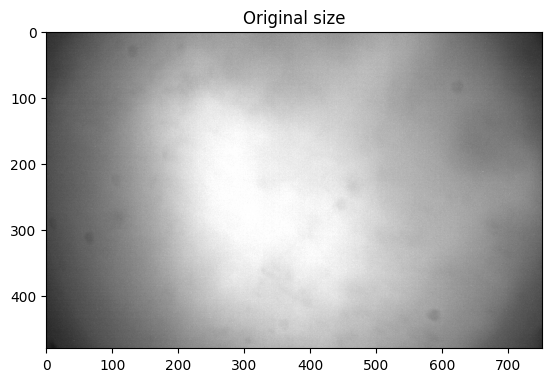

In [13]:
# Visualize a couple of frames here for sanity check

clip = VideoFileClip(msLocalFileList[0])
clip.save_frame(dirExperimentName + '/' + 'frame.png')

img=mpl.image.imread(dirExperimentName + '/' + 'frame.png')
imgplot = plt.imshow(img); plt.title('Original size')

In [14]:
msLocalFileList[0]

'/content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam1.avi'

# Downsample the videos

In [15]:
for video in msLocalFileList:
  clip = VideoFileClip(video)
  resized_clip = clip.resize(1/spatial_downsampling)
  os.remove(video)
  resized_clip.write_videofile(video,codec='rawvideo')

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam1.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam1.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 118.98it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam1.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam2.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam2.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 109.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam2.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam3.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam3.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 110.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam3.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam4.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam4.avi


100%|█████████▉| 1000/1001 [00:07<00:00, 136.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam4.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam5.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam5.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 84.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam5.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam6.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam6.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 124.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam6.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam7.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam7.avi


100%|█████████▉| 1000/1001 [00:14<00:00, 70.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam7.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam8.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam8.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 113.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam8.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam9.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam9.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 85.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam9.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam10.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam10.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 83.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam10.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam11.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam11.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 160.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam11.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam12.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam12.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 106.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam12.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam13.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam13.avi


100%|█████████▉| 1000/1001 [00:12<00:00, 77.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam13.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam14.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam14.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 100.78it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam14.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam15.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam15.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 113.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam15.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam16.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam16.avi


100%|█████████▉| 1000/1001 [00:14<00:00, 71.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam16.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam17.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam17.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 146.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam17.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam18.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam18.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 122.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam18.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam19.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam19.avi


100%|█████████▉| 1000/1001 [00:12<00:00, 78.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam19.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam20.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam20.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 110.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam20.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam21.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam21.avi


100%|█████████▉| 1000/1001 [00:10<00:00, 95.93it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam21.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam22.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam22.avi


100%|█████████▉| 1000/1001 [00:12<00:00, 79.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam22.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam23.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam23.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 90.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam23.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam24.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam24.avi


100%|█████████▉| 1000/1001 [00:12<00:00, 82.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam24.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam25.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam25.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 85.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam25.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam26.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam26.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 100.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam26.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam27.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam27.avi


100%|█████████▉| 1000/1001 [00:13<00:00, 76.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam27.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam28.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam28.avi


100%|█████████▉| 1000/1001 [00:11<00:00, 88.90it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam28.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam29.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam29.avi


100%|█████████▉| 1000/1001 [00:06<00:00, 145.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam29.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam30.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam30.avi


100%|█████████▉| 1000/1001 [00:10<00:00, 94.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam30.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam31.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam31.avi


100%|█████████▉| 1000/1001 [00:14<00:00, 71.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam31.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam32.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam32.avi


100%|█████████▉| 1000/1001 [00:08<00:00, 118.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam32.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam33.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam33.avi


100%|█████████▉| 1000/1001 [00:07<00:00, 131.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam33.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam34.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam34.avi


100%|█████████▉| 1000/1001 [00:16<00:00, 61.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam34.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam35.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam35.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 100.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam35.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam36.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam36.avi


100%|█████████▉| 1000/1001 [00:10<00:00, 97.54it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam36.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam37.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam37.avi


100%|█████████▉| 1000/1001 [00:10<00:00, 98.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam37.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam38.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam38.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 100.94it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam38.avi 



[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam39.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam39.avi


100%|█████████▉| 1000/1001 [00:09<00:00, 100.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam39.avi 

[MoviePy] >>>> Building video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam40.avi
[MoviePy] Writing video /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam40.avi


100%|█████████▉| 1000/1001 [00:10<00:00, 99.35it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/MyDrive/PCell/An3/11_30_2020/H18_M45_S53/Analysis/msCam40.avi 



In [16]:
# You can use this cell to inspect the downsample video
msVideoFilePath=msLocalFileList
ipython_display(clip,width=500)


100%|█████████▉| 1000/1001 [00:07<00:00, 135.94it/s]


Text(0.5, 1.0, 'Downsampled size')

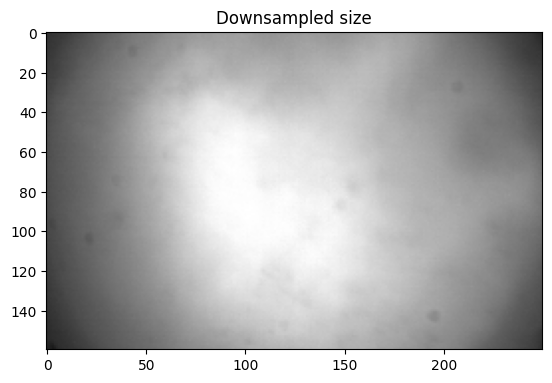

In [17]:
# Make sure the video has been resized
clip = VideoFileClip(msLocalFileList[0])
clip.save_frame(dirExperimentName + '/' + 'downsampled_frame.png')

img=mpl.image.imread(dirExperimentName + '/' + 'downsampled_frame.png')
imgplot = plt.imshow(img); plt.title('Downsampled size')

In [18]:
fnames = msLocalFileList

In [19]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Set parameters for motion correction
Ideally, optimize these for your datasets then stick to these values

In [20]:
# dataset dependent parameters
frate = 30                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data
max_shifts = (5, 5)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between patches (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries
use_cuda = True         # Set to True in order to use GPU
only_init_patch = True
memory_fact = 0.8

mc_dict = {
    #'fnames': fnames,
    'fr': frate,
    'niter_rig': 1,
    'splits_rig': 20,  # for parallelization split the movies in  num_splits chuncks across time
    # if none all the splits are processed and the movie is saved
    'num_splits_to_process_rig': None, # intervals at which patches are laid out for motion correction            
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan,
    'use_cuda' : use_cuda,
    'only_init_patch' : only_init_patch,
    'memory_fact': memory_fact
}

opts = params.CNMFParams(params_dict=mc_dict)

# Perform motion correction (might take a while)

In [21]:
start = time.time() # This is to keep track of how long the analysis is running
if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    
end = time.time()

print(end - start)
print('Motion correction has been done!')

732.9199504852295
Motion correction has been done!


# Plot the motion corrected template and associated shifts

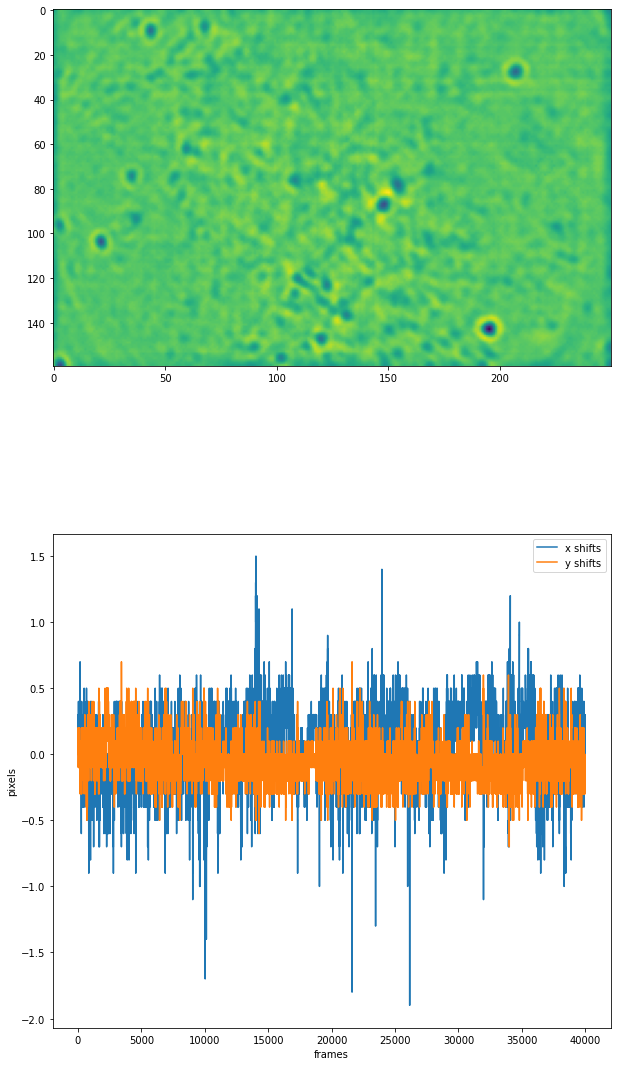

In [22]:
%matplotlib inline
if motion_correct and not pw_rigid:
  plt.figure(figsize=(10,20))
  plt.subplot(2, 1, 1); plt.imshow(mc.total_template_rig);  # % plot template
  plt.subplot(2, 1, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
  plt.legend(['x shifts', 'y shifts'])
  plt.xlabel('frames')
  plt.ylabel('pixels')

# Map the motion corrected video to memory

In [23]:
if motion_correct:  
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)

    bord_px = 0 if border_nan is 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
    
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)
    
print('Motion corrected video has been mapped to memory')

Motion corrected video has been mapped to memory


In [24]:
# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

In [25]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Perform a projection of correlated pixels (and associated signal-to-noise ratio) in motion corrected video
This is important to assess the amounts of local correlations and peak-to-noise ratio as well as seed/initialize CNMFe

In [26]:
# Compute some summary images (correlation and peak to noise) while downsampling temporally 5x to speedup the process and avoid memory overflow
cn_filter, pnr = cm.summary_images.correlation_pnr(images[::5], gSig=3, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile

Text(0.5, 1.0, 'PNR')

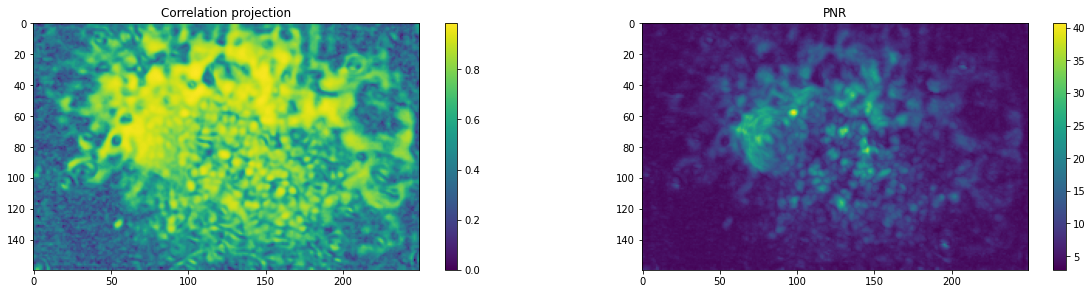

In [27]:
#Plot the results of the correlation/PNR projection
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(2, 2, 2); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')

In [28]:
# Parameters for source extraction and deconvolution
p = 1               # order of the autoregressive system
K = None            # upper bound on number of components per patch, in general None
gSig = (3, 3)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (15, 15)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = .65     # merging threshold, max correlation allowed
rf = 40             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 20    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 1            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 1             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8      # min peak value from correlation image
min_pnr = 8        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor
memory_fact = 0.8 # How much memory to allocate. 1 works for 16Gb, so 0.8 show be optimized for 12Gb.
 
opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'memory_fact': memory_fact,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px})                # number of pixels to not consider in the borders)

# Perform CNMFe extraction
This will take a while. Coffee time!

In [ ]:
start = time.time()
# Perform CNMF
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)
 
end = time.time()
print(end - start)

  res = super(memmap, self).__getitem__(index)

 [1 1 1]
 [1 1 1]]
 [1 1 1]
 [1 1 1]]


(80, 80)


  dims_sliced = images[indeces].shape[1:]

  images = images[indeces]



checking if missing data
Roi Extraction...
One photon initialization..


  dims_sliced = images[indeces].shape[1:]

  images = images[indeces]



checking if missing data
Roi Extraction...
One photon initialization..


To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]



0 neurons have been initialized


  dims_sliced = images[indeces].shape[1:]

  images = images[indeces]



checking if missing data
Roi Extraction...
One photon initialization..


  dims_sliced = images[indeces].shape[1:]

  images = images[indeces]



checking if missing data
Roi Extraction...
One photon initialization..


To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g = np.linalg.lstsq(A, xc[lags + 1:])[0]



0 neurons have been initialized


# Evaluate components

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

min_SNR = 3            # adaptive way to set threshold on the transient size
r_values_min = 0.85    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

# Plot the results for inspection

In [ ]:
%matplotlib inline
 
#How many neurons to plot
neuronsToPlot = 50
 
DeconvTraces = cnm.estimates.S
RawTraces = cnm.estimates.C
SFP = cnm.estimates.A
SFP_dims = list(dims)
SFP_dims.append(SFP.shape[1]) 
print('Spatial foootprints dimensions (height x width x neurons): ' + str(SFP_dims))
 
numNeurons = SFP_dims[2]
 
SFP = np.reshape(SFP.toarray(), SFP_dims, order='F')
 
maxRawTraces = np.amax(RawTraces)
 
plt.figure(figsize=(30,15))
plt.subplot(341);
plt.subplot(345); plt.plot(mc.shifts_rig); plt.title('Motion corrected shifts')
plt.subplot(3,4,9);
plt.subplot(3,4,2); plt.imshow(cn_filter); plt.colorbar(); plt.title('Correlation projection')
plt.subplot(3,4,6); plt.imshow(pnr); plt.colorbar(); plt.title('PNR')
plt.subplot(3,4,10); plt.imshow(np.amax(SFP,axis=2)); plt.colorbar(); plt.title('Spatial footprints')
 
plt.subplot(2,2,2); plt.figure; plt.title('Example traces (first 50 cells)')
plot_gain = 10 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(RawTraces[i,:],'k')
    else:
      trace = RawTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
 
plt.subplot(2,2,4); plt.figure; plt.title('Deconvolved traces (first 50 cells)')
plot_gain = 20 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')      
 
# Save summary figure
plt.savefig(dirExperimentName + '/' + 'summary_figure.svg', edgecolor='w', format='svg', transparent=True)
plt.savefig(dirExperimentName + '/' + 'summary_figure.jpg', edgecolor='w', format='jpg', transparent=True)

In [ ]:
print(dirExperimentName + '/' + 'summary_figure.svg')
plt.savefig(dirExperimentName + '/' + 'summary_figure.jpg', edgecolor='w', format='jpg', transparent=True)

In [ ]:
print('Number of Neurons', SFP_dims[2])

In [ ]:
neuronsToPlot = 100
plt.figure(figsize=(30,35))
plt.figure; plt.title('Deconvolved traces (first 50 cells)')
plot_gain = 20 # To change the value gain of traces
if numNeurons >= neuronsToPlot:
  for i in range(neuronsToPlot):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')
else:
  for i in range(numNeurons):
    if i == 0:
      plt.plot(DeconvTraces[i,:],'k')
    else:
      trace = DeconvTraces[i,:] + maxRawTraces*i/plot_gain
      plt.plot(trace,'k')

# Register the timestamps for analysis

In [ ]:
# Open timestamps.dat here
#try:
 # metadata, res = dbx.files_download(path_to_analyze + '/' + 'timestamp.dat')
#  f = open('timestamp.dat','wb')
##  f = open(path_to_analyze + '/' + 'timestamp.dat','wb')
 # f.write(res.content)
#  f.close
#except FileExistsError:
#  print('Error: timestamp.dat could not be found')
 
with open(path_to_analyze + 'timestamp.dat') as f:
  camNum, frameNum, sysClock, buffer = np.loadtxt(f.readlines()[:-1], dtype='float', comments='#', skiprows=1, unpack = True)
#  a = np.loadtxt(open('/Users/epy/file2.txt','rt').readlines()[:-1]), skiprows=1, dtype=None)
cameraMatched = False
for j in range(int(max(camNum))+1):
  if sum(camNum==j) != 0:
    camFrameList, = np.where(camNum == j)
    camLastFrame = camFrameList[-1]
    LastFrame = frameNum[camLastFrame]
    if (sum(camNum==j) == len(RawTraces[1])) and (LastFrame == len(RawTraces[1])):
      camNumber = j
      mstime_idx = np.where(camNum == j)
      mstime=sysClock[mstime_idx]
      mstime[0] = 0
      maxBufferUsed = max(buffer[mstime_idx])
      cameraMatched = True
      
if cameraMatched is not True:
  print('Problem matching up timestamps for ' + experimentName)
else:
  print('Successfully registered timestamps for ' + experimentName)

In [ ]:
print(path_to_analyze  + 'timestamp.dat')

In [ ]:
# Stop counter and register analysis time
analysis_end = time.time()

analysis_duration = analysis_end - analysis_start

print('Done analyzing. This took a total ' + str(analysis_duration) + ' s')
print('Done analyzing. This took a total ' + str(analysis_duration/60) + ' minutes')

In [ ]:
cnm.save(dirExperimentName + '/analysis_results.hdf5')


# Save the results in HDF5 format

In [ ]:
if save_hdf5: 
  cnm.save(dirExperimentName + '/analysis_results.hdf5')
#  cnm.save(dirExperimentName + '/analysis_results.hdf5[to32]')
  

# Save the results in Matlab format

In [ ]:
save_mat=True

In [ ]:
if save_mat:
  from scipy.io import savemat
  
  results_dict = {
                'dirName': path_to_analyze,
                'numFiles': len(msFileList),
                'framesNum': len(RawTraces[1]),
                'maxFramesPerFile': 1000,
                'height': dims[0],
                'width': dims[1],
                'Experiment': experimentName,
 #               'ExperimentTimestamp': experiment_timestamp,
                'camNumber': 0,
 #               'time': mstime,
                'analysis_time': analysis_time,
                'ds': spatial_downsampling,
                'shifts': mc.shifts_rig,
                'meanFrame': [], #TO DO
                'Centroids': [], #TO DO
                'CorrProj': cn_filter,
                'PeakToNoiseProj': pnr,
                'FiltTraces': [], #TO DO
                'RawTraces': RawTraces.conj().transpose(), #swap time x neurons dimensions
                'SFP': SFP,
                'DeconvTraces':DeconvTraces,
                'numNeurons': SFP_dims[2],
                'analysis_duration': analysis_duration
                }
 
  SFPperm = np.transpose(SFP,[2,0,1])
  sio.savemat(dirExperimentName + '/SFP.mat', {'SFP': SFPperm})
  sio.savemat(dirExperimentName + '/ms.mat', {'ms': results_dict})

# Transfer analysis to Dropbox

# Done analyzing!
From there, you can program an alarm (eg email, text) to notify you that the analysis has been completed.

In [ ]:
msg = 'Your analysis ' + experimentName + ' has just finished!'

server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login(alert_email, alert_email_password)
 
msg = "COLAB WORK FINISH ALERT!"
server.sendmail(alert_email, alert_email, msg)
server.quit()